# Preparations

In [1]:
import sys
import math
import copy
import itertools
import numpy as np
import collections

import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
from sklearn.metrics import roc_curve, roc_auc_score

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.mlab import griddata
from matplotlib.ticker import NullFormatter
from matplotlib.lines import Line2D

from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from higgs_inference.various.utils import interpolate, format_number, asymptotic_p_value
from higgs_inference import settings


# Settings

In [2]:
# Ratio expectation recalibration
use_recalibration = False
use_separate_recalibration_sample = False

# Which benchmark point to use
use_not_trained_benchmark = True

# Which algorithm to use for the PbP vs parameterized vs morphing-aware plot
use_regression_as_pbp_param_aware_example = False  # If False, use carl

# Neyman construction settings
neyman_plots = False
remove_duplicates_for_nc = False

# Neyman observed
neyman_observed_experiment = 2

# Asymptotics settings
use_median_rather_than_asimov = False

# Interpolation
interpolation_method = 'gp' #'linear', 'gp'


In [3]:
colors     = ['0.65','orange','darkgreen', 'mediumblue','c','#be96ff','#CC002E','orange','darkgreen','mediumblue']
linestyles = [   '-',     ':',       '--',         '-.',':',     '-.',     '--',     '-',       '--',         ':']
band_alpha = [ 0.2,       0.4,        0.2,          0.4,0.2,      0.2,      0.4,     0.4,        0.2,         0.2]
linewidths = [1.5 if ls == ':' else 1.5 for ls in linestyles]

scatter_alpha = 1.

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb


In [4]:
thetas = np.load('../data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_observed = 0
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

if use_not_trained_benchmark:
    theta_benchmark = 9
    benchmark_name = 'nottrained'
else:
    theta_benchmark = 422
    benchmark_name = 'trained'
    
pbp_training_thetas = [0, 13, 14, 15, 16, 9, 422, 956, 666, 802, 675, 839, 699, 820, 203, 291, 634, 371, 973, 742, 901, 181, 82, 937, 510, 919, 745, 588, 804, 963, 396, 62, 401, 925, 874, 770, 108, 179, 669, 758, 113, 587, 600, 975, 496, 66, 467, 412, 701, 986, 598, 810, 97, 18, 723, 159, 320, 301, 352, 159, 89, 421, 574, 923, 849, 299, 119, 167, 939, 402, 52, 787, 978, 41, 873, 533, 827, 304, 294, 760, 890, 539, 1000, 291, 740, 276, 679, 167, 125, 429, 149, 430, 720, 123, 908, 256, 777, 809, 269, 851]
basis_thetas = [0, 101, 106, 902, 910,
                226, 373, 583, 747, 841,
                599, 709, 422, 367, 167]
thetas_highlighted = []

#print(thetas[theta1])
#print(thetas[theta_benchmark])

X_observed = np.load('../data/unweighted_events/X_test.npy')

In [5]:
margin_l_absolute = 8. * 0.1
margin_r_absolute = 8. * 0.02
margin_sep_absolute = 8. * 0.02
margin_t_absolute = 8. * 0.02
margin_t_absolute_extra = 8. * 0.10
margin_b_absolute = 8. * 0.08

def calculate_height(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Return height
    return height


def adjust_margins(n_panels=2, width=8., panel_aspect_ratio=1., extra_top_space=False):
    
    if isinstance(n_panels, collections.Sequence):
        n_panels_h, n_panels_v = n_panels
    else:
        n_panels_h = n_panels
        n_panels_v = 1
        
    # Determine top margin
    _margin_t_absolute = margin_t_absolute_extra if extra_top_space else margin_t_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    margin_l = margin_l_absolute / width
    margin_r = margin_r_absolute / width
    margin_l_subsequent = margin_l
    if n_panels_h > 2:
        margin_l_subsequent = margin_r
    margin_sep = margin_sep_absolute / width
    if n_panels_h > 2:
        margin_sep = 0
    margin_sep_total = margin_r + margin_sep + margin_l_subsequent
    panel_width = (1. - margin_l - margin_r - (n_panels_h - 1)*margin_sep_total) / n_panels_h
    
    # Calculate wspace argument of subplots_adjust
    wspace = margin_sep_total / panel_width
    
    # Calculate absolute height
    panel_height_absolute = panel_width * width / panel_aspect_ratio
    height = n_panels_v * (panel_height_absolute + _margin_t_absolute + margin_b_absolute) + (n_panels_v - 1) * margin_sep_absolute
    
    # Calculate horizontal margins. Units: relative to width.
    panel_height = panel_height_absolute / height
    margin_t = _margin_t_absolute / height
    margin_b = margin_b_absolute / height
    margin_sep_total = (margin_t + margin_b + margin_sep_absolute / height)
    
    # Calculate wspace argument of subplots_adjust
    hspace = margin_sep_total / panel_height
    
    # Set margins
    plt.subplots_adjust(left = margin_l,
                        right = 1. - margin_r,
                        bottom = margin_b,
                        top = 1. - margin_t,
                        wspace = wspace,
                        hspace = hspace)
    

# Define strategies and load results

In [6]:
def _load(name, folder='parameterized'):
    return np.load('../results/' + folder + '/' + name + '.npy')

def add_strategy(label, suffix, folder,
                 suffices_ensemble=None, suffix_uncalibrated=None,
                 panel=-1, in_pbp_param_aware_plot=False, in_main_plot=True, is_truth=False,
                 zorder=0, exponentiate_uncalibrated=False):
    
    neyman_string = 'neyman3' if remove_duplicates_for_nc else 'neyman2'
    
    try:
        _expected_llr = _load('llr_' + suffix, folder)
        _r_benchmark = _load('r_' + benchmark_name + '_' + suffix, folder)
    except IOError:
        print('Results for strategy ' + label + ' not found')
        return
    
    try:
        _mse_log_r = _load('mse_logr_' + suffix, folder)
        _trimmed_mse_log_r = _load('trimmed_mse_logr_' + suffix, folder)
        do_mse_log_r = True
    except IOError:
        _mse_log_r = None
        _trimmed_mse_log_r = None
        do_mse_log_r = False
        
    if suffix_uncalibrated is not None:
        try:
            _r_benchmark_uncalibrated = _load('r_' + benchmark_name + '_' + suffix_uncalibrated, folder)
            if exponentiate_uncalibrated:
                _r_benchmark_uncalibrated = np.exp(_r_benchmark_uncalibrated)
            do_calibration = True
        except IOError:
            _r_benchmark_uncalibrated = None
            do_calibration = False
    else:
        _r_benchmark_uncalibrated = None
        do_calibration = False
        
    if suffices_ensemble is not None:
        try:
            _expected_llr_ensemble = []
            for i in range(4):
                _filename = 'llr_' + suffices_ensemble.replace(r'%i', str(i+1))
                _expected_llr_ensemble.append(_load(_filename, folder))
            do_diagnostics = True
        except IOError:
            do_diagnostics = False
            _expected_llr_ensemble = None
    else:
        do_diagnostics = False
        _expected_llr_ensemble = None
    
    try:
        _p_values = _load(neyman_string + '_pvalues_' + suffix, folder)
        _q_thresholds = _load(neyman_string + '_qcut_' + suffix, folder)
        _q_threshold_uncertainties = _load(neyman_string + '_qcut_uncertainties_' + suffix, folder)
        _q_medians = _load(neyman_string + '_qmedian_' + suffix, folder)
        _q_observeds = _load(neyman_string + '_qobserved_' + suffix, folder)
        do_neyman = True
        
        assert not np.all(np.isnan(_q_thresholds)), 'q thresholds contain only NaNs'
        assert not np.all(np.isnan(_q_medians)), 'q medians contain only NaNs'
        assert not np.all(np.isnan(_q_threshold_uncertainties)), 'q threshold uncertainties contain only NaNs'
    except IOError:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        _q_observeds = None
        do_neyman = False
    except AssertionError as err:
        _p_values = None
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
        _q_observeds = None
        do_neyman = False
        
    recalibration_string = 'recalibration_expected_r_vs_sm_' if use_separate_recalibration_sample else 'expected_r_vs_sm_'
        
    try:
        _recalibration_correction = 2. * settings.n_expected_events * np.log(_load(recalibration_string + suffix, folder))
        do_recalibration = True
    except IOError:
        _recalibration_correction = None
        do_recalibration = False
        
    if suffices_ensemble is not None and do_recalibration:
        try:
            _recalibration_correction_ensemble = []
            for i in range(4):
                _filename = recalibration_string + suffices_ensemble.replace(r'%i', str(i+1))
                _ratio_expectation = _load(_filename, folder)
                _recalibration_correction_ensemble.append(2. * settings.n_expected_events * np.log(_ratio_expectation))
            do_ensemble_recalibration = True
        except IOError:
            do_ensemble_recalibration = False
            _recalibration_correction_ensemble = None
    else:
        do_ensemble_recalibration = False
        _recalibration_correction_ensemble = None
        
    try:
        _recalibration_correction_uncertainty = _load('recalibration_uncertainty_' + suffix, folder)
        do_recalibration_uncertainty = True
    except IOError:
        _recalibration_correction_uncertainty = None
        do_recalibration_uncertainty = False
    
    try:
        _r_roam = _load('r_roam_' + suffix, folder)
        do_roaming = True
    except IOError:
        _r_roam = None
        do_roaming = False
        
    try:
        _mle_thetas = _load('neyman_mle_' + suffix, folder)
        do_mle = True
    except IOError:
        _mle_thetas = None
        do_mle = False
        
    try:
        _r_illustration = _load('r_illustration_' + suffix, folder)
        _y_illustration = np.load('../data/unweighted_events/y_illustration.npy')
        
        _roc_fpr, _roc_tpr, _ = roc_curve(_y_illustration[:], - _r_illustration[:])
        _roc_auc = roc_auc_score(_y_illustration[:], - _r_illustration[:])
        
        do_roc = True
    except IOError:
        _roc_fpr = None
        _roc_tpr = None
        _roc_auc = None
        do_roc = False
        
    labels.append(label)
    suffices.append(suffix)
    
    expected_llr.append(_expected_llr)
    expected_llr_ensemble.append(_expected_llr_ensemble)
    mse_log_r.append(_mse_log_r)
    trimmed_mse_log_r.append(_trimmed_mse_log_r)
    p_values.append(_p_values)
    q_medians.append(_q_medians)
    q_observeds.append(_q_observeds)
    q_threshold_uncertainties.append(_q_threshold_uncertainties)
    q_thresholds.append(_q_thresholds)
    mle_thetas.append(_mle_thetas)
    r_benchmark.append(_r_benchmark)
    r_benchmark_uncalibrated.append(_r_benchmark_uncalibrated)
    roc_fpr.append(_roc_fpr)
    roc_tpr.append(_roc_tpr)
    roc_auc.append(_roc_auc)
    recalibration_correction.append(_recalibration_correction)
    recalibration_correction_ensemble.append(_recalibration_correction_ensemble)
    recalibration_correction_uncertainty.append(_recalibration_correction_uncertainty)
    
    index = len(labels) - 1
    if is_truth:
        truth_index = index
    if panel >= 0 and panel < 3:
        panel_indices[panel].append(index)
    in_pbp_param_aware_plots.append(in_pbp_param_aware_plot)
    in_main_plots.append(in_main_plot)
    
    zorders.append(zorder)
        
    if (do_neyman or do_recalibration or do_ensemble_recalibration or do_recalibration_uncertainty
        or do_roc or do_mle or do_diagnostics or do_calibration):
        supported = []
        if do_diagnostics:
            supported.append('ensemble')
        if do_recalibration:
            supported.append('recalibration')
        if do_ensemble_recalibration:
            supported.append('ens. rec.')
        if do_recalibration_uncertainty:
            supported.append('recalibration uncertainty')
        if do_neyman:
            supported.append('NC')
        if do_mle:
            supported.append('MLE')
        if do_roc:
            supported.append('ROC')
        if do_calibration:
            supported.append('calibration')
        supported = ', '.join(supported)
            
        print('Loaded strategy {}: {} ({})'.format(len(labels) - 1, label, supported))
        
    else:
        print('Loaded strategy {}: {}'.format(len(labels) - 1, label))
    

In [7]:
labels = []
suffices = []
folders = []

truth_index = 0
panel_indices = ([], [])
panel_indices = ([], [], [])
in_pbp_param_aware_plots = []
in_main_plots = []

expected_llr = []
expected_llr_ensemble = []
mse_log_r = []
trimmed_mse_log_r = []
p_values = []
q_medians = []
q_observeds = []
q_thresholds = []
q_threshold_uncertainties = []
mle_thetas = []
r_benchmark = []
r_benchmark_uncalibrated = []
roc_tpr = []
roc_fpr = []
roc_auc = []
recalibration_correction = []
recalibration_correction_ensemble = []
recalibration_correction_uncertainty = []

zorders = []

add_strategy('Truth', 'truth', 'truth', 'truth_denom%i', 'truth_calibrated', is_truth=True)

add_strategy('2D histogram', 'histo_2d_asymmetricbinning', 'histo', 'histo_2d_asymmetricbinning_denom%i', panel=0)
add_strategy('CARL', 'carl_calibrated_shallow', 'parameterized', 'carl_calibrated_shallow_denom%i', 'carl_shallow', panel=0)
add_strategy('SALLY', 'scoreregression_rotatedscore_deep', 'score_regression', 'scoreregression_rotatedscore_deep_denom%i', 'scoreregression_deep', panel=1, exponentiate_uncalibrated=True)
add_strategy('ROLR', 'regression_calibrated', 'parameterized', 'regression_calibrated_denom%i', 'regression', panel=1)
add_strategy('CASCAL', 'combined_calibrated_deep', 'parameterized', 'combined_calibrated_deep_denom%i', 'combined_deep', panel=2)
add_strategy('RASCAL', 'combinedregression_calibrated_deep', 'parameterized', 'combinedregression_calibrated_deep_denom%i', 'combinedregression_deep', panel=2)

print('')

if use_regression_as_pbp_param_aware_example:
    add_strategy('ROLR point by point', 'regression_calibrated', 'point_by_point',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=2)
    add_strategy('ROLR parameterized', 'regression_calibrated', 'parameterized',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=3)
    add_strategy('ROLR morphing-aware', 'regression_calibrated_aware', 'parameterized',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=1)
else:
    add_strategy('CARL point by point', 'carl_calibrated', 'point_by_point',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=2)
    add_strategy('CARL parameterized', 'carl_calibrated_shallow', 'parameterized',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=3)
    add_strategy('CARL morphing-aware', 'carl_calibrated_aware_shallow', 'parameterized',
                 panel=-1, in_pbp_param_aware_plot=True, in_main_plot=False, zorder=1)

n_strategies = len(labels)

Loaded strategy 0: Truth (ensemble, NC, MLE, ROC, calibration)
Loaded strategy 1: 2D histogram (ensemble, NC, ROC)
Loaded strategy 2: CARL (ensemble, recalibration, ens. rec., recalibration uncertainty, NC, ROC, calibration)
Loaded strategy 3: SALLY (ensemble, recalibration, ens. rec., NC, ROC, calibration)
Loaded strategy 4: ROLR (ensemble, recalibration, ens. rec., recalibration uncertainty, NC, ROC, calibration)
Loaded strategy 5: CASCAL (ensemble, recalibration, ens. rec., recalibration uncertainty, NC, ROC, calibration)
Loaded strategy 6: RASCAL (ensemble, recalibration, ens. rec., recalibration uncertainty, NC, ROC, calibration)

Loaded strategy 7: CARL point by point
Loaded strategy 8: CARL parameterized (recalibration, recalibration uncertainty, NC, ROC)
Loaded strategy 9: CARL morphing-aware


In [8]:
panel_indices = ([1, 2], [4, 3], [5, 6])

# Interpolation

In [9]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# One run
interpolated_expected_llr_mle = []
interpolated_expected_llr = []
interpolated_expected_llr_rc_error = []

# Ensemble
interpolated_expected_llr_median = []
interpolated_expected_llr_min = []
interpolated_expected_llr_max = []

for llr, llr_ensemble, rc, rc_ensemble, rc_error in zip(expected_llr, expected_llr_ensemble,
                                                        recalibration_correction,
                                                        recalibration_correction_ensemble,
                                                        recalibration_correction_uncertainty):
    
    if rc is None:
        rc = np.zeros_like(llr)
    if rc_ensemble is None:
        rc_ensemble = [rc for i in range(4)]
    rc_ensemble = np.asarray(rc_ensemble)
    if not use_recalibration:
        rc[:] = 0.
        rc_ensemble[:,:] = 0.
        rc_error = None
        
    _llr, _mle = interpolate(thetas, llr + rc, xx, yy, method=interpolation_method, subtract_min=False)
    _llr -= llr[settings.theta_observed] + rc[settings.theta_observed]
    
    if rc_error is not None:
        _rc_error, _  = interpolate(thetas, rc_error, xx, yy, method=interpolation_method, subtract_min=False)
    else:
        _rc_error = np.zeros_like(_llr)
    
    if llr_ensemble is not None:
        _llr_ensemble = [_llr]
        
        for i, (llr_this_run, rc_this_run) in enumerate(zip(llr_ensemble, rc_ensemble)):
            _llr_this_run, _ = interpolate(thetas, llr_this_run + rc_this_run, xx, yy,
                                      method=interpolation_method, subtract_min=False)
            _llr_this_run -= llr_this_run[settings.theta_observed] + rc_this_run[settings.theta_observed]
            _llr_ensemble.append(_llr_this_run)
        _llr_ensemble = np.asarray(_llr_ensemble)
        
        _llr_median = np.median(_llr_ensemble, axis=0)
        _llr_min = np.min(_llr_ensemble, axis=0)
        _llr_max = np.max(_llr_ensemble, axis=0)
            
    else:
        _llr_median = _llr
        _llr_min = _llr
        _llr_max = _llr
        
    interpolated_expected_llr.append(_llr)
    interpolated_expected_llr_mle.append(_mle)
    interpolated_expected_llr_median.append(_llr_median)
    interpolated_expected_llr_min.append(_llr_min)
    interpolated_expected_llr_max.append(_llr_max)
    interpolated_expected_llr_rc_error.append(_rc_error)

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.62924187e-05, -6.88368685e-08,  1.44381915e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 71, 'nit': 23, 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.57901482e-05,  4.81075025e-05,  1.54254485e-01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 22, 'warnflag': 2}
  " state: %s" % convergence_dict)


In [10]:
if neyman_plots:
    interpolated_q_medians = []
    interpolated_q_observeds = []
    interpolated_q_thresholds = []
    interpolated_cl_excluded = []
    interpolated_cl_excluded_observed = []

    for i, (_q_median, _q_observed, _q_threshold, _q_threshold_uncertainty) in \
        enumerate(zip(q_medians, q_observeds, q_thresholds, q_threshold_uncertainties)):
            
        print('Starting strategy {} / {}'.format(i + 1, n_strategies))

        if _q_median is None or _q_observed is None or _q_threshold is None or _q_threshold_uncertainty is None:
            interpolated_q_medians.append(None)
            interpolated_q_observeds.append(None)
            interpolated_q_thresholds.append(None)
            interpolated_cl_excluded.append(None)
            interpolated_cl_excluded_observed.append(None)
            continue

        try:
            cut = np.all(np.isfinite(_q_threshold),axis=1) & (np.isfinite(_q_median)) & np.all(np.isfinite(_q_threshold_uncertainty),axis=1)
            
            _interpolated_q_median, _ = interpolate(thetas[cut], _q_median[cut],
                                                    xx, yy,
                                                    method='gp',
                                                    length_scale_default=0.1, length_scale_min=0.01,
                                                    length_scale_max=1.,
                                                    matern_exponent=2.5,
                                                    noise_level=0.01)
            
            _interpolated_q_observed, _ = interpolate(thetas[cut], _q_observed[cut, neyman_observed_experiment],
                                                      xx, yy,
                                                      method='gp',
                                                      length_scale_default=0.1, length_scale_min=0.01,
                                                      length_scale_max=1.,
                                                      matern_exponent=2.5,
                                                      noise_level=0.01)
            
            _interpolated_q_thresholds = []
            for j in range(len(settings.confidence_levels)):
                _qthresh, _ = interpolate(thetas[cut], _q_threshold[cut, j], xx, yy,
                                         z_uncertainties_thetas=2*_q_threshold_uncertainty[cut, j],
                                         method='gp',
                                         length_scale_default=1., length_scale_min=0.5, length_scale_max=2.,
                                         matern_exponent=2.5,
                                         noise_level=0.01)
                _interpolated_q_thresholds.append(copy.deepcopy(_qthresh))
            _interpolated_q_thresholds = np.asarray(_interpolated_q_thresholds)

            _interpolated_cl_excluded = np.asarray([_interpolated_q_median - _interpolated_q_thresholds[j]
                                                    for j in range(_interpolated_q_thresholds.shape[0])])
            _interpolated_cl_excluded_observed = np.asarray([_interpolated_q_observed - _interpolated_q_thresholds[j]
                                                             for j in range(_interpolated_q_thresholds.shape[0])])

            interpolated_q_medians.append(_interpolated_q_median)
            interpolated_q_observeds.append(_interpolated_q_observed)
            interpolated_q_thresholds.append(_interpolated_q_thresholds)
            interpolated_cl_excluded.append(_interpolated_cl_excluded)
            interpolated_cl_excluded_observed.append(_interpolated_cl_excluded_observed)
            
            # Debug plot
            zmin, zmax = -20.,20.
            plt.figure(figsize=(10,8))

            plt.subplot(2,2,1)
            zi = np.clip(_interpolated_q_median,zmin,zmax)
            cs = plt.contourf(xi, yi, zi, 100, cmap='viridis_r', vmin=zmin, vmax=zmax)
            plt.scatter(thetas[:,0], thetas[:,1], c=_q_median[:],
                        s=30., lw=0.5, cmap='viridis_r', edgecolors='k', vmin=zmin, vmax=zmax)
            cbar = plt.colorbar()
            cs = plt.contour(xi, yi, zi, [settings.q_threshold],
                             linewidths=1.5, colors='w',
                             linestyles='solid')
            plt.xlim(-1.,1.)
            plt.ylim(-1.,1.)
            plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
            plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
            cbar.set_label('Median observed $q$')
            
            for j in range(len(settings.confidence_levels)):
                plt.subplot(2,2,j+2)
                zi = np.clip(_interpolated_q_thresholds[j], zmin, zmax)
                cs = plt.contourf(xi, yi, zi, 100, cmap='viridis_r', vmin=zmin, vmax=zmax)
                plt.scatter(thetas[:,0], thetas[:,1], c=_q_threshold[:,j],
                            s=30., lw=0.5, cmap='viridis_r', edgecolors='k', vmin=zmin, vmax=zmax)
                cbar = plt.colorbar()
                plt.xlim(-1.,1.)
                plt.ylim(-1.,1.)
                plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
                plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
                cbar.set_label('$q$ threshold')

            plt.tight_layout()
            plt.savefig("../figures/neyman/cl_interpolation_" + suffices[i] + ".pdf")

        except ValueError as err:
            print(err)
            interpolated_q_medians.append(None)
            interpolated_q_observeds.append(None)
            interpolated_q_thresholds.append(None)
            interpolated_cl_excluded.append(None)
            interpolated_cl_excluded_observed = []
            

# Calculate p values from Asimov data

In [11]:
# One run
interpolated_p_values_asymptotics = []
interpolated_p_values_asymptotics_minus_rc_error = []
interpolated_p_values_asymptotics_plus_rc_error = []

# Ensemble
interpolated_p_values_asymptotics_median = []
interpolated_p_values_asymptotics_lower_bound = []
interpolated_p_values_asymptotics_upper_bound = []

if False:
    for i, (llrs, rc_errors) in enumerate(zip(interpolated_expected_llr, interpolated_expected_llr_rc_error)):
        print('Starting', i+1, '/', len(interpolated_expected_llr))

        pvals = []
        pvals_plus = []
        pvals_minus = []

        for llr, rc_error in zip(llrs.flatten(), rc_errors.flatten()):
            pvals.append(asymptotic_p_value(llr, use_median_rather_than_asimov=use_median_rather_than_asimov))
            pvals_plus.append(asymptotic_p_value(llr + rc_error, use_median_rather_than_asimov=use_median_rather_than_asimov))
            pvals_minus.append(asymptotic_p_value(llr - rc_error, use_median_rather_than_asimov=use_median_rather_than_asimov))

        pvals = np.asarray(pvals)
        pvals_plus = np.asarray(pvals_plus)
        pvals_minus = np.asarray(pvals_minus)

        pvals = pvals.reshape(llrs.shape)
        pvals_plus = pvals_plus.reshape(llrs.shape)
        pvals_minus = pvals_minus.reshape(llrs.shape)

        interpolated_p_values_asymptotics.append(pvals)
        interpolated_p_values_asymptotics_plus_rc_error.append(pvals_plus)
        interpolated_p_values_asymptotics_minus_rc_error.append(pvals_minus)
    
for i, (medians, mins, maxs) in enumerate(zip(interpolated_expected_llr_median,
                                              interpolated_expected_llr_min, interpolated_expected_llr_max)):
    print('Starting', i+1, '/', len(interpolated_expected_llr_median))
    
    pvals_median = []
    pvals_lower = []
    pvals_upper = []
                         
    for median, lmin, lmax in zip(medians.flatten(), mins.flatten(), maxs.flatten()):
        pvals_median.append(asymptotic_p_value(median, use_median_rather_than_asimov=use_median_rather_than_asimov))
        pvals_lower.append(asymptotic_p_value(lmin, use_median_rather_than_asimov=use_median_rather_than_asimov))
        pvals_upper.append(asymptotic_p_value(lmax, use_median_rather_than_asimov=use_median_rather_than_asimov))
                         
    pvals_median = np.asarray(pvals_median)
    pvals_lower = np.asarray(pvals_lower)
    pvals_upper = np.asarray(pvals_upper)
                         
    pvals_median = pvals_median.reshape(medians.shape)
    pvals_lower = pvals_lower.reshape(medians.shape)
    pvals_upper = pvals_upper.reshape(medians.shape)
                         
    interpolated_p_values_asymptotics_median.append(pvals_median)
    interpolated_p_values_asymptotics_lower_bound.append(pvals_lower)
    interpolated_p_values_asymptotics_upper_bound.append(pvals_upper)
    

Starting 1 / 10
Starting 2 / 10
Starting 3 / 10
Starting 4 / 10
Starting 5 / 10
Starting 6 / 10
Starting 7 / 10
Starting 8 / 10
Starting 9 / 10
Starting 10 / 10


# PbP vs parameterized vs aware plot

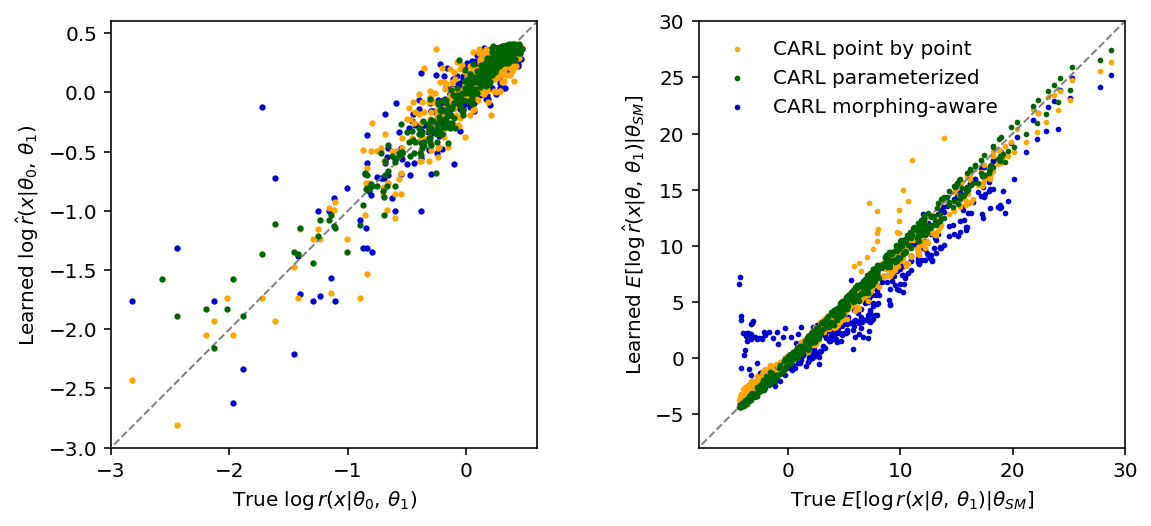

In [12]:
fig = plt.figure(figsize=(8., calculate_height(2,8.)))



ax = plt.subplot(1, 2, 1)

xmin, xmax = -3., 0.6
skip = 100

plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')

for s in range(n_strategies):
    if in_pbp_param_aware_plots[s]:
        plt.scatter(np.log(r_benchmark[truth_index][::skip]),
                    np.log(r_benchmark[s][::skip]),
                    marker='o', alpha=1., s=10., c=colors[s], lw=0.,
                    zorder=zorders[s],
                    label=labels[s])

#plt.legend(loc='lower right', edgecolor='white', facecolor='white', framealpha=1.)

plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log \, r(x| \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")


    
ax = plt.subplot(1, 2, 2)

xmin, xmax = -8., 30.
skip = 2
    
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')

for s in range(n_strategies):
    if in_pbp_param_aware_plots[s]:
        plt.scatter(expected_llr[truth_index][::skip], expected_llr[s][::skip],
                    marker='o', color=colors[s], alpha=scatter_alpha, 
                    s=8., lw=0.,
                    zorder=zorders[s],
                    label=labels[s])

plt.legend(loc='upper left', edgecolor='white', facecolor='white', framealpha=1.)

plt.xlim(xmin, xmax)
plt.ylim(xmin, xmax)
plt.xlabel(r"True $E[\log \, r(x | \theta,\,\theta_1)|\theta_{SM}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(x | \theta,\,\theta_1)|\theta_{SM}]$")



adjust_margins(2,8.)
plt.savefig("../figures/pbp_parameterized_aware.pdf")

# Calibration plots

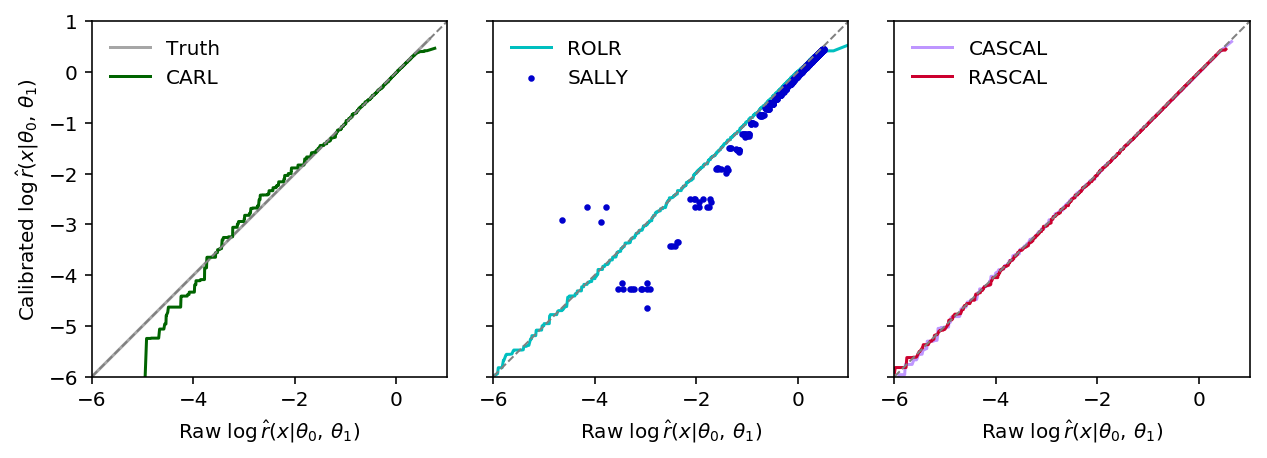

In [13]:
xmin, xmax = -6, 1.
skip = 50

fig = plt.figure(figsize=(9., calculate_height(3,9.)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)

    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
    
    for s in [truth_index]*(panel==0) + panel_indices[panel]:
        if r_benchmark_uncalibrated[s] is None:
            continue
        
        order = r_benchmark_uncalibrated[s].argsort()
        
        if s == 3:
            plt.scatter(np.log(r_benchmark_uncalibrated[s])[::50],
                        np.log(r_benchmark[s])[::50],
                        s=5., alpha=scatter_alpha,
                        c=colors[s], label=labels[s])
        else:
            plt.plot(np.log(r_benchmark_uncalibrated[s][order]),
                     np.log(r_benchmark[s][order]),
                     zorder=zorders[s],
                     c=colors[s], lw=1.5, ls='-', label=labels[s])
        
    plt.legend(loc='upper left', frameon=False)
    
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)
    plt.xlabel(r"Raw $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")
    if panel == 0:
        plt.ylabel(r"Calibrated $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/calibration.pdf")

# Benchmark theta: approximate vs exact r(x)

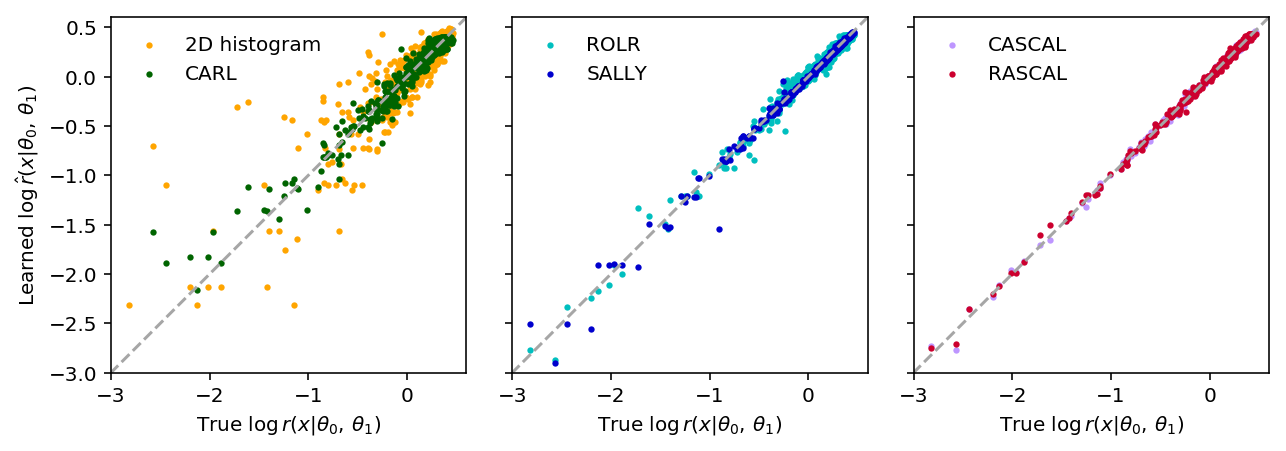

In [14]:
xmin, xmax = -3., 0.6
skip = 100

fig = plt.figure(figsize=(9., calculate_height(3,9.)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)

    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1.5, c=colors[truth_index])
    
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter(np.log(r_benchmark[truth_index][::skip]),
                    np.log(r_benchmark[s][::skip]),
                    marker='o', alpha=1., s=10., c=colors[s], lw=0., zorder=zorders[s],
                    label=labels[s])
        
    plt.legend(loc='upper left', edgecolor='white', facecolor='white', framealpha=1.)
    
    plt.xlim(xmin,xmax)
    plt.ylim(xmin,xmax)
    plt.xlabel(r"True $\log \, r(x| \theta_0,\,\theta_1)$")
    if panel == 0:
        plt.ylabel(r"Learned $\log \, \hat{r}(x| \theta_0,\,\theta_1)$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/r_scatter.pdf")

# Exact vs approximate expected log likelihood ratios

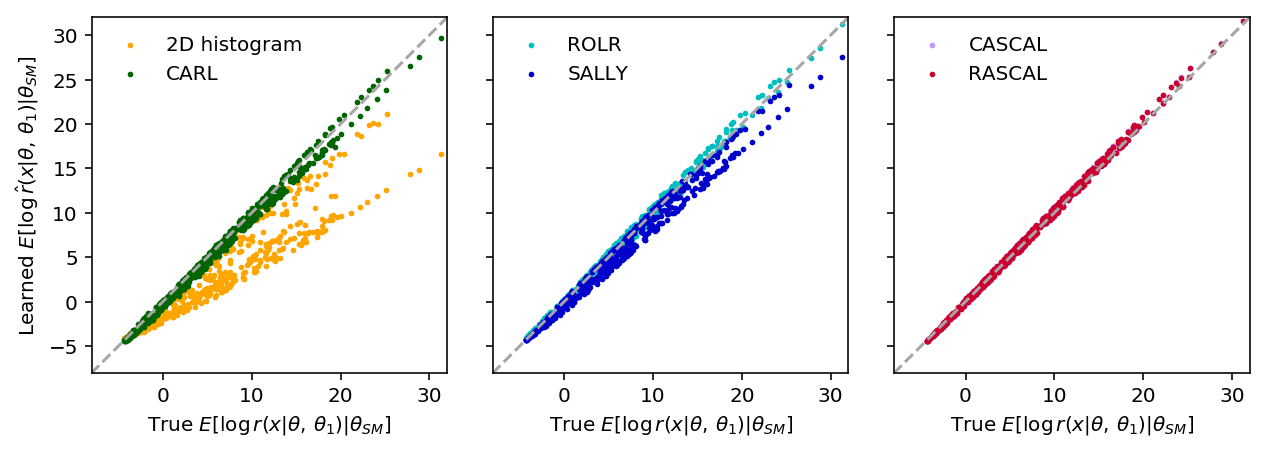

In [15]:
xmin, xmax = -8., 32.
skip = 2

fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
    
    plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1.5, c=colors[truth_index])
    
    for s in panel_indices[panel]:
        plt.scatter(expected_llr[truth_index][::skip], expected_llr[s][::skip],
                    marker='o', color=colors[s], alpha=scatter_alpha, 
                    s=8., lw=0., zorder=zorders[s],
                    label=labels[s])
        
    plt.legend(loc='upper left', edgecolor='white', facecolor='white', framealpha=1.)
    
    plt.xlim(xmin, xmax)
    plt.ylim(xmin, xmax)
    plt.xlabel(r"True $E[\log \, r(x | \theta,\,\theta_1)|\theta_{SM}]$")
    if panel == 0:
        plt.ylabel(r"Learned $E[\log \, \hat{r}(x | \theta,\,\theta_1)|\theta_{SM}]$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/expected_likelihood_scatter.pdf")

# Benchmark theta: ROC curves

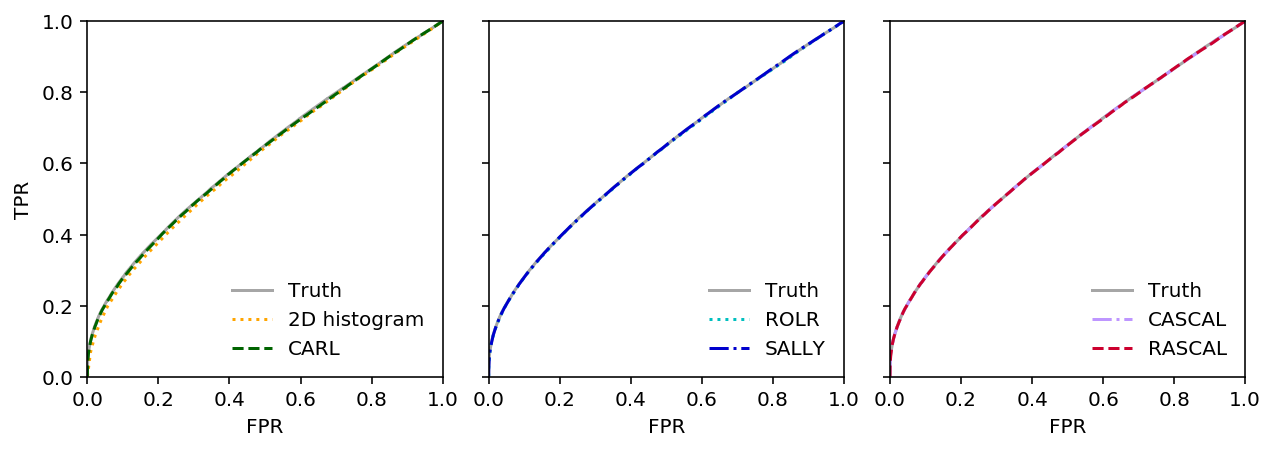

In [16]:
fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

for panel in range(3):
    
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
    
    # plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
    
    for s in [truth_index] + panel_indices[panel]:
        plt.plot(roc_fpr[s], roc_tpr[s],
                 color=colors[s], ls=linestyles[s], lw=linewidths[s], zorder=zorders[s],
                 label=labels[s])
        
    plt.legend(loc='lower right',frameon=False)
    
    plt.xlim(0., 1.)
    plt.ylim(0., 1.)
    plt.xlabel(r"FPR")
    if panel == 0:
        plt.ylabel(r"TPR")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/roc.pdf")

In [17]:
roc_auc[0]

0.6276455265

# CL contours from asymptotics (ensemble errors)

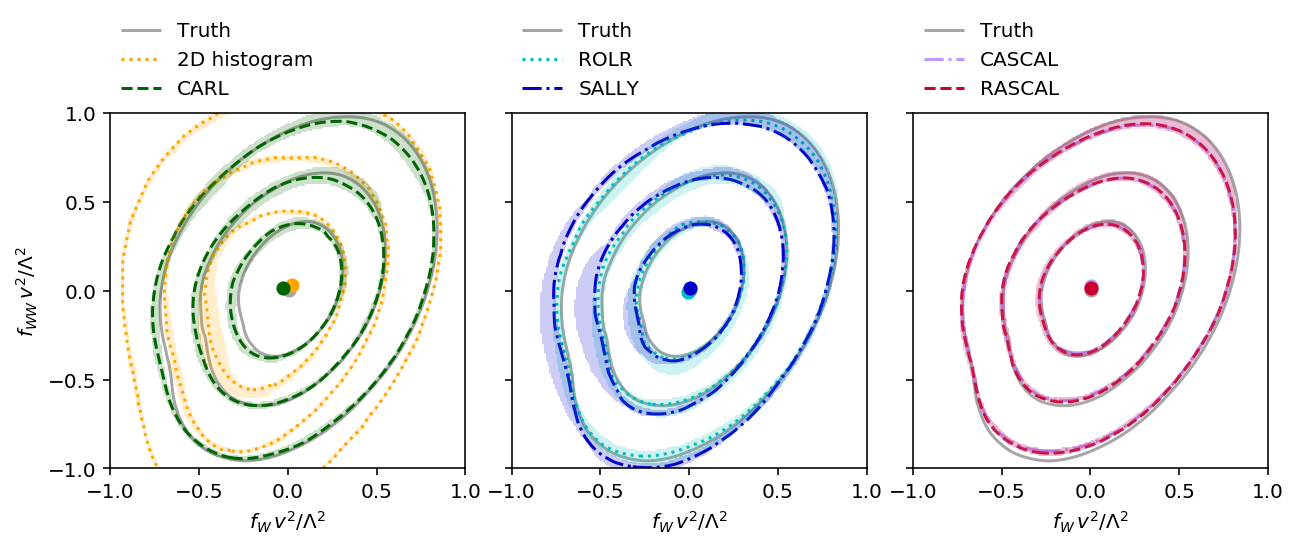

In [18]:
# Grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# Error band function
def plot_errorbands(xi, yi, zi_upper, zi_lower, color):
    for threshold in np.sort(1. - settings.confidence_levels):
        band = (zi_upper > threshold) * (zi_lower < threshold) + (zi_upper < threshold) * (zi_lower > threshold)
        plt.contourf(xi, yi, band, [0.5,2.5],
                     colors=color,
                     alpha=0.2)

fig = plt.figure(figsize=(9.,calculate_height(3,9.,1.,True)))

for panel in range(3):
    
    # Axis (shared y axis)
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
        
    # Error bands (envelope)
    for s in panel_indices[panel]:
        #if s < 2:
        #    continue
        plot_errorbands(xi, yi,
                        interpolated_p_values_asymptotics_upper_bound[s],
                        interpolated_p_values_asymptotics_lower_bound[s],
                        colors[s])
        #cs = plt.contour(xi, yi, interpolated_p_values_asymptotics_upper_bound[s], 
        #                 np.sort(1. - settings.confidence_levels),
        #                 linewidths=0.5, colors=colors[s], alpha=0.5,
        #                 linestyles='-')
        #cs = plt.contour(xi, yi, interpolated_p_values_asymptotics_lower_bound[s], 
        #                 np.sort(1. - settings.confidence_levels),
        #                 linewidths=0.5, colors=colors[s], alpha=0.5,
        #                 linestyles='-')
        
    # CL contours (median)
    for s in [truth_index] + panel_indices[panel]:
        cs = plt.contour(xi, yi, interpolated_p_values_asymptotics_median[s], 
                         np.sort(1. - settings.confidence_levels),
                         linewidths=linewidths[s], colors=colors[s],
                         zorder=zorders[s],
                         linestyles=linestyles[s])
        cs.collections[0].set_label(labels[s])

    # MLE
    for s in [truth_index] + panel_indices[panel]:
        plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                    [yi[interpolated_expected_llr_mle[s][0]]],
                    marker='o', c=colors[s], s=50, lw=0, zorder=10 + zorders[s])

    # Legend
    plt.legend(loc='lower left', bbox_to_anchor=(-0.02,.99), frameon=False)

    # Axis details
    plt.xlim(-1, 1.)
    plt.ylim(-1, 1.)
    plt.xticks(np.linspace(-1.,1.,5))
    plt.yticks(np.linspace(-1.,1.,5))
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    if panel==0:
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.,1.,True)
plt.savefig("../figures/constraints_asymptotics.pdf")


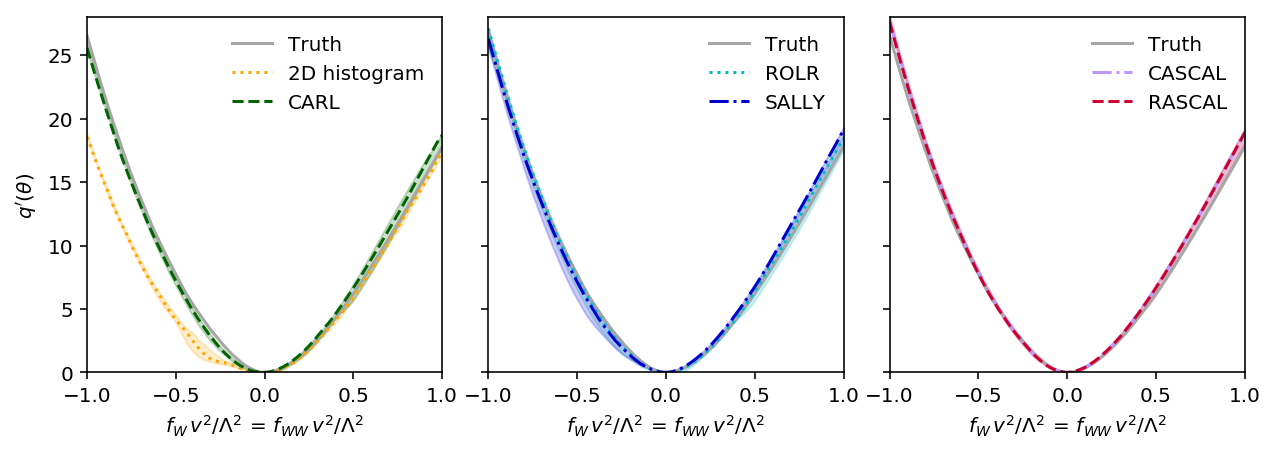

In [23]:
# Grid
xi = np.linspace(-1.0, 1.0, 200)

# Error band function
def plot_errorbands(xi, yi_upper, yi_lower, color):
    plt.fill_between(xi, yi_upper, yi_lower,
                     color=color, alpha=0.2)

fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

for panel in range(3):
    
    # Axis (shared y axis)
    if panel == 0:
        ax0 = plt.subplot(1, 3, panel+1)
    else:
        ax = plt.subplot(1, 3, panel+1, sharey=ax0)
    
    # Error bands (envelope)
    for s in panel_indices[panel]:
            
        yi_min = np.diag(interpolated_expected_llr_min[s])
        yi_max = np.diag(interpolated_expected_llr_max[s])
    
        plot_errorbands(xi, yi_min, yi_max,
                        colors[s])
        #plt.plot(xi, yi_min,
        #         lw=0.5, color=colors[s], alpha=0.5,
        #         ls='-')
        #plt.plot(xi, yi_max,
        #         lw=0.5, color=colors[s], alpha=0.5,
        #         ls='-')
        
    # CL contours (median)
    for s in [truth_index] + panel_indices[panel]:
        yi_median = np.diag(interpolated_expected_llr_median[s])
        plt.plot(xi, yi_median,
                 lw=linewidths[s], color=colors[s],
                 ls=linestyles[s], label=labels[s])

    # Legend
    plt.legend(loc='upper right', frameon=False)

    # Axis details
    plt.xlim(-1., 1.)
    plt.ylim(0., 28.)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2 \, = \, f_{WW} \, v^2 / \Lambda^2$")
    if panel==0:
        plt.ylabel(r"$q'(\theta)$")
    else:
        plt.setp(ax.get_yticklabels(), visible=False)

adjust_margins(3,9.)
plt.savefig("../figures/expected_llr_diagonal.pdf")


# Asymptotic CL contours (E[r] errors)

In [20]:
if False:
    # Grid
    thetas_filtered = thetas[:]
    xi = np.linspace(-1.0, 1.0, 200)
    yi = np.linspace(-1.0, 1.0, 200)
    xx, yy = np.meshgrid(xi, yi)

    # Error band function
    def plot_errorbands(xi, yi, zi_upper, zi_lower, color, alpha):
        for threshold in np.sort(1. - settings.confidence_levels):
            band = (zi_upper > threshold) * (zi_lower < threshold) + (zi_upper < threshold) * (zi_lower > threshold)
            plt.contourf(xi, yi, band, [0.5,2.5],
                         colors=color,
                         alpha=alpha)

    fig = plt.figure(figsize=(9.,calculate_height(3,9.)))

    for panel in range(3):

        # Axis (shared y axis)
        if panel == 0:
            ax0 = plt.subplot(1, 3, panel+1)
        else:
            ax = plt.subplot(1, 3, panel+1, sharey=ax0)

        # Error bands (envelope)
        for s in [truth_index] + panel_indices[panel]:
            plot_errorbands(xi, yi,
                            interpolated_p_values_asymptotics_plus_rc_error[s],
                            interpolated_p_values_asymptotics_minus_rc_error[s], 
                            colors[s], band_alpha[s])

        # CL contours (median)
        for s in [truth_index] + panel_indices[panel]:
            cs = plt.contour(xi, yi, interpolated_p_values_asymptotics[s], 
                             np.sort(1. - settings.confidence_levels),
                             linewidths=linewidths[s], colors=colors[s],
                             linestyles=linestyles[s])
            cs.collections[0].set_label(labels[s])

        # MLE
        plt.scatter([xi[interpolated_expected_llr_mle[truth_index][1]]],
                    [yi[interpolated_expected_llr_mle[truth_index][0]]],
                    marker='o', c=colors[truth_index], s=50, lw=0, zorder=10)
        for s in panel_indices[panel]:
            plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                        [yi[interpolated_expected_llr_mle[s][0]]],
                        marker='o', c=colors[s], s=50, lw=0, zorder=10)

        # Legend
        plt.legend(loc='upper left')

        # Axis details
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        if panel==0:
            plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

    adjust_margins(3,9.)
    plt.show()



# Expected CL contours from Neyman construction

In [21]:
if neyman_plots:
    fig = plt.figure(figsize=(9.,calculate_height(3,9.,1,True)))

    for panel in range(3):

        if panel == 0:
            ax0 = plt.subplot(1, 3, panel+1)
        else:
            ax = plt.subplot(1, 3, panel+1, sharey=ax0)

        for s in [truth_index] + panel_indices[panel]:
            if interpolated_cl_excluded[s] is None:
                continue

            for cl in range(len(interpolated_cl_excluded[truth_index])):
                cs = plt.contour(xi, yi, interpolated_cl_excluded[s][cl], [0.],
                                 linewidths=linewidths[s], colors=colors[s],
                                 linestyles=linestyles[s])
                if cl==0:
                    cs.collections[0].set_label(labels[s])

        plt.legend(loc='lower left', bbox_to_anchor=(-0.02,0.99), frameon=False)

        plt.xlim(-1, 1.)
        plt.ylim(-1, 1.)# 1.6)
        plt.xticks(np.linspace(-1.,1.,5))
        plt.yticks(np.linspace(-1.,1.,5))
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        if panel==0:
            plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

    adjust_margins(3,9.,1,True)
    plt.savefig("../figures/constraints_nc.pdf")

# Observed CL contours from Neyman construction

In [22]:
for neyman_observed_experiment in range(10):

    interpolated_q_observeds = []
    interpolated_cl_excluded_observed = []

    for i, (qobs, _qthreshs) in enumerate(zip(q_observeds, interpolated_q_thresholds)):

        if qobs is None or i > 6:
            interpolated_q_observeds.append(None)
            interpolated_cl_excluded_observed.append(None)
            continue

        _qobs, _ = interpolate(thetas, qobs[:, neyman_observed_experiment], xx, yy,
                               method='linear',
                               length_scale_default=0.1, length_scale_min=0.01, length_scale_max=1.,
                               matern_exponent=2.5,
                               noise_level=0.01)

        _obs_excludeds = np.asarray([_qobs - _qthreshs[j] for j in range(_qthreshs.shape[0])])

        interpolated_q_observeds.append(_qobs)
        interpolated_cl_excluded_observed.append(_obs_excludeds)

    fig = plt.figure(figsize=(9.,calculate_height(3,9.,0.769)))

    for panel in range(3):

        if panel == 0:
            ax0 = plt.subplot(1, 3, panel+1)
        else:
            ax = plt.subplot(1, 3, panel+1, sharey=ax0)

        for s in [truth_index] + panel_indices[panel]:
            if interpolated_cl_excluded[s] is None:
                continue

            for cl in range(len(interpolated_cl_excluded_observed[truth_index])):
                cs = plt.contour(xi, yi, interpolated_cl_excluded_observed[s][cl], [0.],
                                 linewidths=linewidths[s], colors=colors[s],
                                 linestyles=linestyles[s])
                if cl==0:
                    cs.collections[0].set_label(labels[s])

        plt.legend(loc='upper left')

        plt.xlim(-1, 1.)
        plt.ylim(-1, 1.6)
        plt.xticks(np.linspace(-1.,1.,5))
        plt.yticks(np.linspace(-1.,1.,5))
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        if panel==0:
            plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

    adjust_margins(3,9.,0.769)
    plt.show()
    

NameError: name 'interpolated_q_thresholds' is not defined

# Best fit thetas

In [ ]:
s = 0 # Fixed strategy for now
mle = thetas[mle_thetas[s]]

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.hist2d(mle[:,0], mle[:,1], range=[[-1.,1.],[-1.,1.]], bins=(21,21), normed=True, cmap='viridis')

# now determine nice limits by hand:
binwidth = 0.05
xymax = np.max([np.max(np.fabs(mle[:,0])), np.max(np.fabs(mle[:,1]))])
lim = (int(xymax/binwidth) + 1) * binwidth

axScatter.set_xlim((-lim, lim))
axScatter.set_ylim((-lim, lim))

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(mle[:,0], bins=bins)
axHisty.hist(mle[:,1], bins=bins, orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()